In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

import xgboost as xgb

from pandas.plotting import scatter_matrix


pd.options.display.max_columns = 2000
pd.options.display.max_rows = 200

In [ ]:
def print_def(variable_name):
    """
    Pass in a variable name as a string, print its defintion.
    Definitions included with the original dataset. 
    Only works with ORIGINAL feature names.
    """
    
    try:
        if  not ("definitions_" in globals()):
            try:
                global definitions_
                definitions_ = pd.read_csv("LC_definitions.csv")       
            except:
                print(f"Could not find \"LC_definitions.csv\" in {pwd}.")
        print(variable_name, "-", definitions_.loc[definitions_.LoanStatNew == variable_name, "Description"].iloc[0])
    except:
        print("New feature, not in original dictionary.")

In [ ]:
def quick_XGB(alg, X, y, X_t, y_t, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, cutoff=0.5):
    # create XGBoost models and perform cross-validation
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(data=X, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    model_ = alg.fit(X, y)
        
    #Predict test set:
    dtrain_predictions = model_.predict(X_t)
    dtrain_predprob = model_.predict_proba(X_t)[:,1]
    #Print model report:
    df2_ = pd.DataFrame()
    df2_["target_"] = y_t.copy()
    df2_["preds"] = np.where(dtrain_predprob>cutoff, 1, 0)
    
    
    print("Model Report")
    cm_ = metrics.confusion_matrix(y_t, df2_.preds)
    print(cm_)
    print(f"Adjusted accuracy: {((cm_[0][0]+cm_[1][1])/(cm_[0][0]+cm_[0][1]+cm_[1][0]+cm_[1][1])).round(3)}")
    print(f"Adjusted recall: {((cm_[1][1])/(cm_[1][0]+cm_[1][1])).round(3)}")
    print(f"Adjusted precision:{((cm_[1][1])/(cm_[0][1]+cm_[1][1])).round(3)}")
    print("Raw Accuracy : %.4g" % metrics.accuracy_score(y_t, dtrain_predictions))
    print("AUC Score (Test): %f" % metrics.roc_auc_score(y_t, dtrain_predprob))
                   
    feat_imp = pd.Series(model_.get_booster().get_score(importance_type='weight')).nlargest(10).sort_values()
    print(feat_imp)
    feat_imp.plot(kind='barh', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    
    # Accuracy vs Recall Graph
    cutoff_ = []
    recall_ = []
    accuracy_ = []
    
    benefit_ = []
    
    for co_ in np.arange(0.1, .99, 0.01):
        cutoff_.append(co_)
        preds_g = np.where(dtrain_predprob>co_, 1, 0)
        cm_ = metrics.confusion_matrix(y_t, preds_g)
        recall_.append(((cm_[1][1])/(cm_[1][0]+cm_[1][1])).round(3))
        accuracy_.append(((cm_[0][0]+cm_[1][1])/(cm_[0][0]+cm_[0][1]+cm_[1][0]+cm_[1][1])).round(3))
        # Select values for correctly predicting fraud and incorrectly identifying a transaction as fraudulent.
        benefit_.append(600*cm_[1][1] - 50*cm_[0][1])
    r_a_tradeoff = [0] + [100*((recall_[i]-recall_[i-1]) + accuracy_[i]-accuracy_[i-1]) for i in range(1, len(recall_))]
    df_graph = pd.DataFrame(list(zip(cutoff_, recall_, accuracy_, benefit_, r_a_tradeoff)), 
                            columns=["cutoff", "recall", "accuracy", "benefit", "tradeoff"])
    
    df_graph["ar"] = (df_graph.recall + df_graph.accuracy)/2
    
    print(f"Max Accuracy cutoff: {(df_graph.sort_values(by='accuracy', ascending=False).cutoff.iloc[0]).round(2)}")
    print(f"Max benefit cutoff: {(df_graph.sort_values(by='benefit', ascending=False).cutoff.iloc[0]).round(2)}")
    plt.scatter(x="cutoff", y="recall", data=df_graph, s=4, label="Proportion of Fraudulent Transaction Correctly Identified")
    plt.scatter(x="cutoff", y="accuracy", data=df_graph, s=4, c="red", label="Proportion of Correctly Classified Transactions")
    plt.scatter(x="cutoff", y="ar", data=df_graph, s=4, c="black", label="Cumulative Tradeoff")
    plt.xlabel("Cutoff Percentage")
    plt.legend()
    plt.ylim(-1, 1)
    plt.show()
    
    plt.scatter(x="cutoff", y="benefit", data=df_graph, s=4, c="red")
    plt.title("Benefit Curve by Cutoff Point")
    plt.show()
    
    return model_

In [51]:
# Load datasets and dummy-out objects
df_train = pd.read_csv("lending_club_sample_preprocessed_train.csv")
df_test = pd.read_csv("lending_club_sample_preprocessed_test.csv")
df_validate = pd.read_csv("lending_club_sample_preprocessed_validate.csv")
df_biased = pd.read_csv("lending_club_biased_preprocessed.csv")

In [52]:
XG_drop_cols = ["loan_status"]+list(df_train.select_dtypes(include='object').columns)

df_train = df_train.drop(labels=XG_drop_cols, axis=1)
df_test = df_test.drop(labels=XG_drop_cols, axis=1)
df_validate = df_validate.drop(labels=XG_drop_cols, axis=1)
df_biased = df_biased.drop(labels=XG_drop_cols, axis=1)

In [55]:
X_train = df_train.drop(labels=["target"], axis=1)
X_test = df_test.drop(labels=["target"], axis=1)

y_train = df_train.target
y_test = df_test.target

In [56]:
# Create XGBClassifier object
xg = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=4,
 min_child_weight=1,
 gamma=1, reg_lambda=2,
 subsample=0.6,
 colsample_bytree=0.4,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 eval_metric='aucpr',
 seed=2112)

Model Report
[[4371    8]
 [  76  545]]
Adjusted accuracy: 0.983
Adjusted recall: 0.878
Adjusted precision:0.986
Raw Accuracy : 0.9832
AUC Score (Test): 0.995193
total_rec_int           20.0
total_rec_late_fee      20.0
recoveries              24.0
installment             27.0
issue_date_year         32.0
funded_amnt             37.0
total_pymnt_inv         43.0
last_pymnt_amnt         45.0
total_rec_prncp         73.0
last_fico_range_high    87.0
dtype: float64


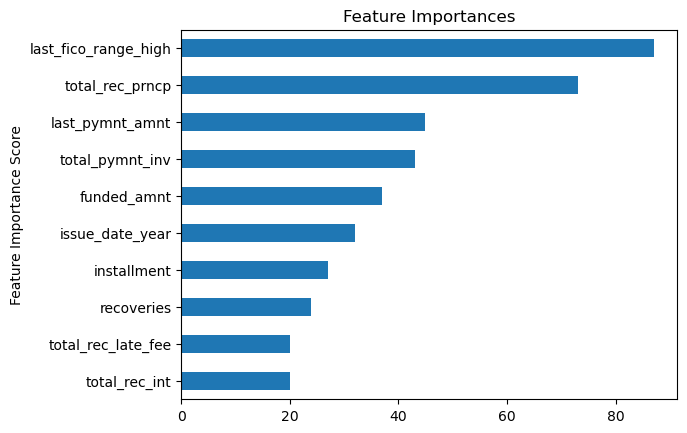

Max Accuracy cutoff: 0.37
Max benefit cutoff: 0.17


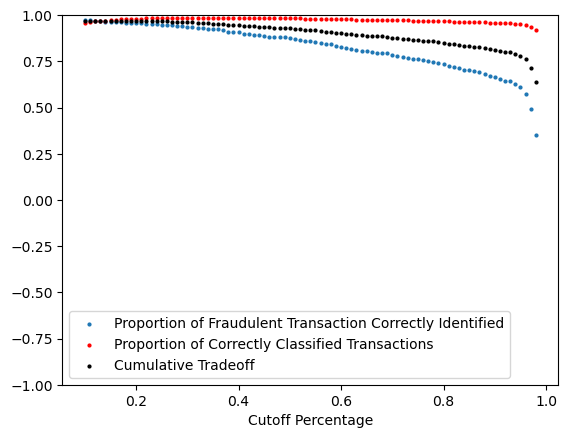

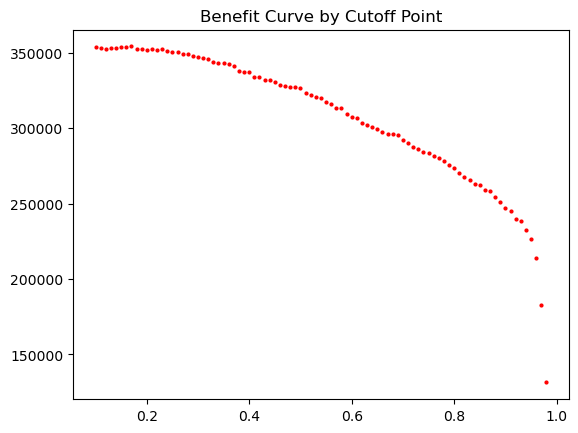

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [57]:
quick_XGB(xg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, cutoff=0.5)